In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For ARIMA
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# For LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


In [3]:
# Fetch Apple (AAPL) data from Yahoo Finance
ticker = "AAPL"
df = yf.download(ticker, start="2015-01-01", end="2023-01-01")

# Focus on the 'Close' price
df = df[['Close']]
df.dropna(inplace=True)

print(df.head())


[*********************100%%**********************]  1 of 1 completed

                Close
Date                 
2015-01-02  27.332500
2015-01-05  26.562500
2015-01-06  26.565001
2015-01-07  26.937500
2015-01-08  27.972500



/var/folders/w5/dzyh6b2s0tjdwdblx286ggkh0000gn/T/ipykernel_1403/2351048747.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


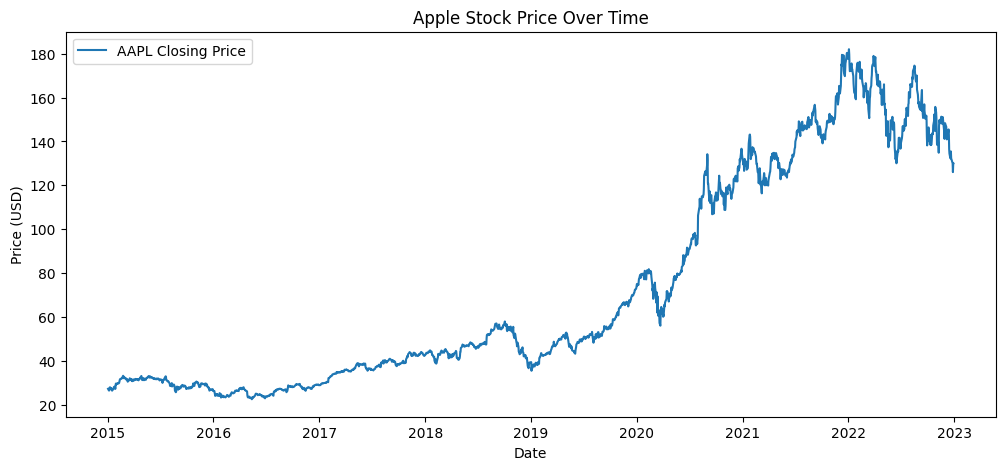

In [4]:
plt.figure(figsize=(12, 5))
plt.plot(df['Close'], label='AAPL Closing Price')
plt.title('Apple Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [5]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -0.656313
p-value: 0.857743


In [6]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['Close'], start_p=1, start_q=1, max_p=5, max_q=5, 
                          d=1, seasonal=False, trace=True, error_action='ignore', 
                          suppress_warnings=True, stepwise=True)
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8031.006, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8036.057, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8031.683, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8031.276, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8035.708, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8032.839, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8032.863, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=8031.472, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8031.902, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8031.078, Time=0.97 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=8031.064, Time=0.06 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.157 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2

In [7]:
train_size = int(len(df) * 0.9)  # 90% for training
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported

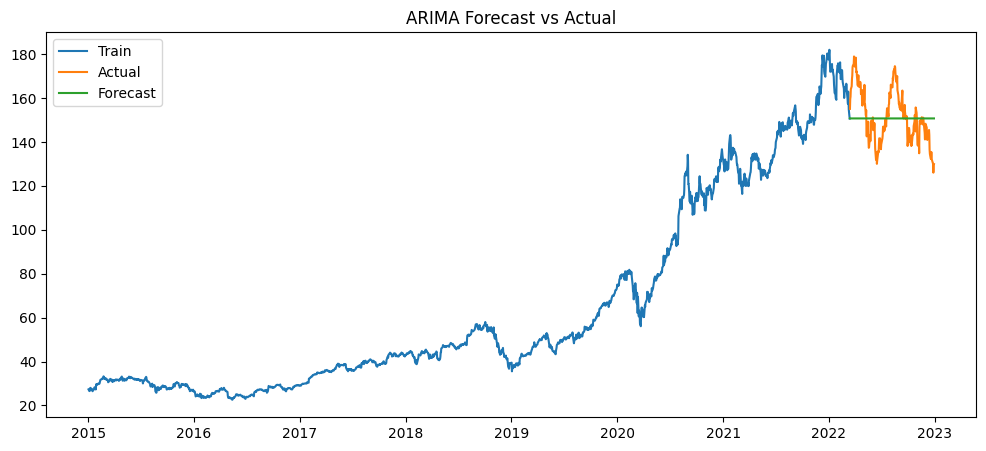

RMSE: 12.222322795158362


In [8]:
# Build and fit SARIMAX (similar to ARIMA but more general)
model = SARIMAX(train_data['Close'], order=(1, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)

# Forecast for the test period
forecast = model_fit.forecast(steps=len(test_data))
forecast.index = test_data.index

# Plot
plt.figure(figsize=(12, 5))
plt.plot(train_data['Close'], label='Train')
plt.plot(test_data['Close'], label='Actual')
plt.plot(forecast, label='Forecast')
plt.title('ARIMA Forecast vs Actual')
plt.legend()
plt.show()

# Evaluate with RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test_data['Close'], forecast))
print("RMSE:", rmse)


In [9]:
# Convert DataFrame to numpy array
dataset = df['Close'].values.reshape(-1, 1)

# Scale data to [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

training_size = int(len(scaled_data) * 0.9)
train_scaled = scaled_data[:training_size]
test_scaled = scaled_data[training_size:]


In [10]:
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

sequence_length = 60
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

# Reshape for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training shape:", X_train.shape, y_train.shape)
print("Testing shape:", X_test.shape, y_test.shape)


Training shape: (1752, 60, 1) (1752,)
Testing shape: (142, 60, 1) (142,)


In [11]:
model_lstm = Sequential()

model_lstm.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(50, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))  # Output layer (predicting 1 value: the price)

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/10
50/50 [==============================] - 2s 24ms/step - loss: 0.0076 - val_loss: 0.0038
Epoch 2/10
50/50 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 3/10
50/50 [==============================] - 1s 20ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 4/10
50/50 [==============================] - 1s 20ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 5/10
50/50 [==============================] - 1s 20ms/step - loss: 9.8782e-04 - val_loss: 0.0017
Epoch 6/10
50/50 [==============================] - 1s 21ms/step - loss: 9.0074e-04 - val_loss: 0.0011
Epoch 7/10
50/50 [==============================] - 1s 20ms/step - loss: 9.5641e-04 - val_loss: 0.0011
Epoch 8/10
50/50 [==============================] - 1s 20ms/step - loss: 9.0846e-04 - val_loss: 0.0017
Epoch 9/10
50/50 [==============================] - 1s 20ms/step - loss: 9.0994e-04 - val_loss: 0.0023
Epoch 10/10
50/50 [==============================] - 1s 21ms/step - loss: 7.9077e-04 - va

5/5 [==============================] - 0s 5ms/step


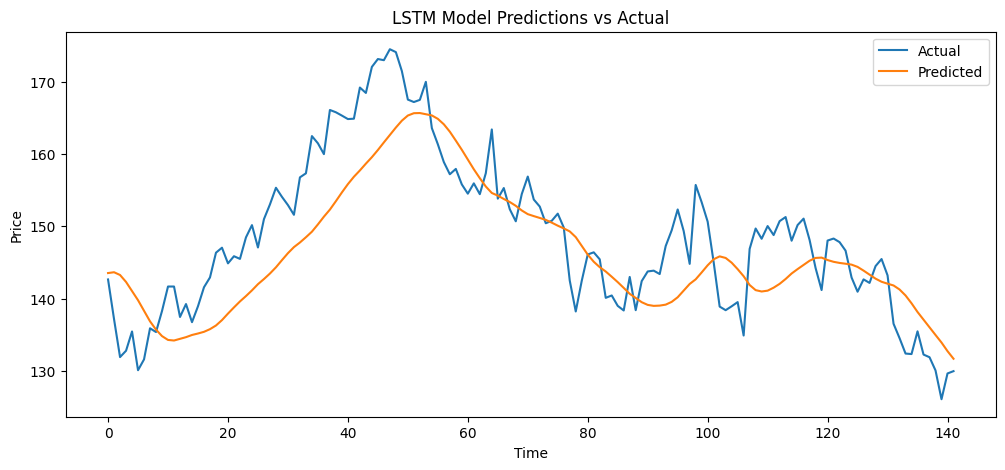

LSTM RMSE: 6.621699339880615


In [12]:
# Predictions on test set
y_pred_scaled = model_lstm.predict(X_test)

# Invert scaling
y_pred = scaler.inverse_transform(y_pred_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot
plt.figure(figsize=(12,5))
plt.plot(actual, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('LSTM Model Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Evaluate with RMSE
rmse_lstm = np.sqrt(mean_squared_error(actual, y_pred))
print("LSTM RMSE:", rmse_lstm)
